In [24]:
import numpy as np
from scipy.stats import bernoulli
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# Takes a list of n bits and produces degree*n bits, `degree' bits produced by broadcast process from each input bit 
def expandArrayFast(L,degree,down_eps):
    A = np.zeros((len(L),degree))
    for j in range(0,degree):
        biased_bits = bernoulli.rvs(0.5+down_eps,size=len(L))
        A[:,j] = biased_bits * L + (1-biased_bits)*(1-L)
    return A.flatten()


# Takes a list L of n*degree numbers, produces n numbers by applying local Bayes 
def contractArrayFast(L,degree,up_eps):
    M = np.reshape(L,(-1,degree))
    #weights1 = [(0.5+eps)*a + (0.5-eps)*(1 - a) for a in P]
    weights1 = (0.5 - up_eps) + 2*up_eps*M
    #weights0 = [(0.5-eps)*a + (0.5+eps)*(1 - a) for a in P]
    weights2 = 1.0- weights1    
    #w1 = np.prod(weights1)
    w1 = np.prod(weights1,axis=1)
    #w0 = np.prod(weights0)
    w0 = np.prod(weights2,axis=1)
    #z = w1 + w0
    z = w1 + w0
    return w1/z

########## Population Dynamics
# up_eps  -- epsilon for upward local Bayes
# down_eps -- epsilon for downward broadcast
# init_marginals -- a numpy array with marginals in [0,1]
# depth = number of iterations
def runPopDynamics(initMarginals, degree, depth, up_eps, down_eps):
    numSamples = len(initMarginals)
    current = initMarginals
    ones_array = np.ones(numSamples)
    for i in range(1,depth):
        #   Creating child bits via broadcast process
        childBits = expandArrayFast(ones_array,degree,down_eps)
        #   Creating child Biases by randomly choosing from old empirical distribution
        childBias = np.random.choice(current,numSamples*degree)
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   newSamples = childBits*childBias + (1-childBits)*(1-childBias)
        current = contractArrayFast(1 - childBits - childBias + 2*childBits*childBias, degree, up_eps)
    return current



# Applies expandArrayFast recursively depth times, takes a list L of n bits and produces all leaves of depth trees 
# starting from each bit separately.
def expandTreeFast(L,depth,degree,down_eps):
    prevL = L
    for i in range(0,depth):
        currentL = expandArrayFast(prevL,degree,down_eps)
        prevL    = currentL
    return prevL


# Applies contract Array recursively
def contractTreeFast(L,depth,degree,up_eps):
    prevL = L
    for i in range(0,depth):
        currentL = contractArrayFast(prevL,degree,up_eps)
        prevL    = currentL
    return prevL

# Compute empirical distribution
def get_empirical_dist(numTrials,depth,degree,up_eps,down_eps):
    blockSize = 50
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        leafSigns = expandTreeFast(rootList,depth,degree,down_eps)
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafSigns,depth,degree,up_eps)))
    return emp_dist

# testing fixed-point ness
def test_Fixed_Point(old_emp_dist,numTrials,depth,degree,up_eps,down_eps):
    new_emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = expandTreeFast(rootList,depth,degree,down_eps)
        #   Creating leaf Biases by randomly choosing from old empirical distribution
        leafBias = np.random.choice(old_emp_dist,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        new_emp_dist = np.concatenate((new_emp_dist,contractTreeFast(leafMessages,depth,degree,up_eps)))
    return new_emp_dist

# testing universality
def test_Universality(marginals,numTrials,depth,degree,up_eps,down_eps):
    new_emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = expandTreeFast(rootList,depth,degree,down_eps)
        #   Creating leaf Biases by randomly choosing from old empirical distribution
        leafBias = np.random.choice(marginals,len(leafBits))
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        new_emp_dist = np.concatenate((new_emp_dist,contractTreeFast(leafMessages,depth,degree,up_eps)))
    return new_emp_dist

# Fix the marginals, but vary the broadcast to plot the histogram
def test_Fix_Marginals(marginals,numTrials,depth,degree,up_eps,down_eps):
    emp_dist = np.array([])
    for i in range(0,numTrials,blockSize):
        rootList = np.ones(blockSize)
        #   Creating leaf bits via broadcast process
        leafBits = (expandTreeFast(rootList,depth,degree,down_eps)).reshape((blockSize,-1))
        #   Copying marginals again and again
        leafBias = marginals
        #   Computing the effective bias of leaves, after incorporating bits and bias  
        #   leafMessages = leafBits*leafBias + (1-LeafBits)*(1-LeafBias)
        leafMessages = 1 - leafBits - leafBias + 2*leafBits*leafBias
        emp_dist = np.concatenate((emp_dist,contractTreeFast(leafMessages.flatten(),depth,degree,up_eps)))
    return emp_dist    


def mymain():
    blockSize = 100
    numTrials = 10000
    max_depth = 10
    # Fixed marginals with value mu changing depth
    #Input marginal distribution parameters
    mu = 0.6
    sigma = 0.2
    #SBM parameters
    degree    = 3
    depth     = 100

    #Population Dynamics Parameters
    popDynSamples = 100000
    up_eps = 0.4
    down_eps = 0.0
    
    print("Population Dynamics with fixed marginals to mu = ",mu)
    print("Degree = ",degree,"depth =",depth,"up_eps =", up_eps, "down_eps =",down_eps)
    fixed_marginals = np.full(popDynSamples, mu)
    fix_theta = runPopDynamics(fixed_marginals,degree,depth,up_eps,down_eps)
    print("Output Mean with Fixed Marginals:",np.mean(fix_theta))
    print("Output Variance with Fixed Marginals:",np.sqrt(np.var(fix_theta)))
    plt.hist(fix_theta,50,alpha=0.3)

#   Population dynamics with marginals by uniform distribution between mu-sigma, to mu + sigma
    print("Population dynamics with marginals from uniform distribution over mu-sigma,mu+sigma with mu=",mu," sigma= ",sigma)
    fixed_uniform_marginals = np.random.uniform(mu-2*sigma,mu + 2*sigma,popDynSamples)
    fix_uniform_theta = runPopDynamics(fixed_uniform_marginals,degree,depth,up_eps,down_eps)
    print("Output Mean with Fixed Uniform Marginals:",np.mean(fix_uniform_theta))
    print("Output Variance with Fixed Uniform Marginals:",np.sqrt(np.var(fix_uniform_theta)))
    plt.hist(fix_uniform_theta,50)


#    Population dynamics with 2-point distribution
#    Mixture 1
    print("Pop dynamics from uniform distribution over two points: mu-sigma,mu+sigma with mu=",mu+0.1," sigma= ",sigma)
    fixed_mixture_marginals = np.random.choice([mu+0.1-sigma,mu+0.1 + sigma],popDynSamples,[0.5,0.5])
    fix_mixture_theta = runPopDynamics(fixed_mixture_marginals,degree,depth,up_eps,down_eps)
#   print("Mean of marginals", np.mean(fixed_mixture_marginals))
    print("Output Mean with Fixed Mixture Marginals:",np.mean(fix_mixture_theta))
    print("Output Variance with Fixed Mixture Marginals:",np.sqrt(np.var(fix_mixture_theta)))
    plt.hist(fix_mixture_theta,50)
    
    
#    print("Computing Emprical Distribution:")
#    theta = get_empirical_dist(numTrials,depth,degree,up_eps,down_eps)
#    mean_theta = np.mean(theta)
#    sigma_theta = np.var(theta)
#    print("Empirical Distribution Mean:",np.mean(theta))
#    print("Empirical Distribution Variance:",np.sqrt(np.var(theta)))
#    plt.hist(theta,50)
    
#    print("Testing Fixed-pointness:")
#    new_theta = test_Fixed_Point(theta,numTrials,depth,degree,up_eps,down_eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)

#    print("Testing Universality with Gaussian inputs:")
#    marginals = np.random.normal(mean_theta,sigma_theta,numTrials)
#    new_theta = test_Universality(marginals,numTrials,depth,degree,up_eps,down_eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)

#    print("Testing Chaos:")
    #Changing mean and variance arbitrarily
#    marginals = np.random.normal(mean_theta,sigma_theta/100.0,numTrials)
#    new_theta = test_Universality(marginals,numTrials,depth,degree,up_eps,down_eps)
#    print("New empirical Distribution Mean:",np.mean(new_theta))
#    print("New Empirical Distribution Variance:",np.sqrt(np.var(new_theta)))
#    plt.hist(new_theta,50)


#    print("Testing One Parameter Family")
    # Using random gaussian marginals with mean mu, variance sigma
 #   gaussian_marginals = np.random.normal(mu,sigma,numTrials)
 #   gaussian_theta = test_Universality(gaussian_marginals,numTrials,depth,degree,up_eps,down_eps)
 #   print("Output Mean with Gaussian marginals:",np.mean(gaussian_theta))
 #   print("Output variance with Gaussian marginales",np.sqrt(np.var(gaussian_theta)))
 #   plt.hist(gaussian_theta,50)
    
    
    # Fixed marginals by Gaussian mean mu and variance sigma
#    fixed_gaussian_marginals = np.random.normal(mu,sigma,degree**depth)
#    fix_gaussian_theta = test_Fix_Marginals(fixed_gaussian_marginals,numTrials,depth,degree,up_eps,down_eps)
#    print("Length of fix_theta",len(fix_gaussian_theta))
#    print("Output Mean with Fixed Gaussian Marginals:",np.mean(fix_gaussian_theta))
#    print("Output Variance with Fixed Gaussian Marginals:",np.sqrt(np.var(fix_gaussian_theta)))
#    plt.hist(fix_gaussian_theta,50)


#    Fixed marginals from a point mixture
#    Mixture 1
#    print("Fixed marginals from uniform distribution over two points: mu-sigma,mu+sigma with mu=",mu," sigma= ",sigma)
#    fixed_mixture_marginals = np.random.choice([mu-sigma,mu + sigma],degree**depth,[0.5,0.5])
#    fix_mixture_theta = test_Fix_Marginals(fixed_mixture_marginals,numTrials,depth,degree,up_eps,down_eps)
#    print("Mean of marginals", np.mean(fixed_mixture_marginals))
#    print("Output Mean with Fixed Mixture Marginals:",np.mean(fix_mixture_theta))
#    print("Output Variance with Fixed Mixture Marginals:",np.sqrt(np.var(fix_mixture_theta)))
#    plt.hist(fix_mixture_theta,50)

#    print("Fixed marginals to mu = ",mu)
#    fixed_marginals = np.full(degree**depth, mu)
#    fix_theta = test_Fix_Marginals(fixed_marginals,numTrials,depth,degree,up_eps,down_eps)
#    print("depth = ",depth)
#    print("Output Mean with Fixed Marginals:",np.mean(fix_theta))
#    print("Output Variance with Fixed Marginals:",np.sqrt(np.var(fix_theta)))
#    plt.hist(fix_theta,50,alpha=0.3)
#    plt.show()
#    
#    print("Fixing marginals at mu = ",mu, " and varying depth from 2 to ",max_depth)
#    print("degree = ",degree," epsilon ",eps)
#    for my_depth in range(6,max_depth):
#        fixed_marginals = np.full(degree**my_depth, mu)
#        fix_theta = test_Fix_Marginals(fixed_marginals,numTrials,my_depth,degree,up_eps,down_eps)
#        print("depth = ",my_depth)
#        print("Output Mean with Fixed Marginals:",np.mean(fix_theta))
#        print("Output Variance with Fixed Marginals:",np.sqrt(np.var(fix_theta)))
#        plt.hist(fix_theta,50,alpha=0.3)
#    plt.show()
#    return

Population Dynamics with fixed marginals to mu =  0.6
Degree =  3 depth = 100 up_eps = 0.4 down_eps = 0.0
Output Mean with Fixed Marginals: 0.5010704529909418
Output Variance with Fixed Marginals: 0.34053482024771986
Population dynamics with marginals from uniform distribution over mu-sigma,mu+sigma with mu= 0.6  sigma=  0.2
Output Mean with Fixed Uniform Marginals: 0.49882835462132535
Output Variance with Fixed Uniform Marginals: 0.3397495308073322
Pop dynamics from uniform distribution over two points: mu-sigma,mu+sigma with mu= 0.7  sigma=  0.2
Output Mean with Fixed Mixture Marginals: 0.5003931345985965
Output Variance with Fixed Mixture Marginals: 0.33981798877667285


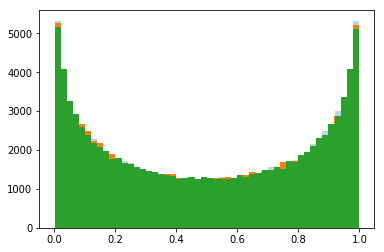

In [105]:
mymain()